Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Amazon Books
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [5]:
# importa dataset 'lastfm playlists'
data = pd.read_csv("../datasets/Books.csv", names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset_name = 'Amazon_Books'
user_col = 'user_id'

: 

: 

In [ ]:
data

,0001713353,A1C6M8LCIX4M6M,5.0,1123804800
0,0001713353,A1REUF3A1YCPHM,5.0,1112140800
1,0001713353,A1YRBRK2XM5D5,5.0,1081036800
2,0001713353,A1V8ZR5P78P4ZU,5.0,1077321600
3,0001713353,A2ZB06582NXCIV,5.0,1475452800
4,0001713353,ACPQVNRD3Z09X,5.0,1469750400
...,...,...,...,...
51311615,B01HJDS76Y,A3P8PUZFHWFK1E,4.0,1467244800
51311616,B01HJDS76Y,A26Q9T9G9MTX9S,1.0,1467158400
51311617,B01HJEB422,AB9M1MQPBAS2J,5.0,1487030400
51311618,B01HJEB422,A2TO93KMH3DJIK,5.0,1485648000


In [4]:
# Necessary Preprocess - create date from timestamp
data['date'] = data['timestamp'].apply(lambda x: datetime.strptime(x.split('T')[0], '%Y-%m-%d') )
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

In [5]:
# this lets me sample the first 10% of the dataset to avoid cold start.
# data.iloc[ :int( 0.1*data.shape[0] ) ]

## Evaluating Time defined Buckets 

How many interactions occur in each month?

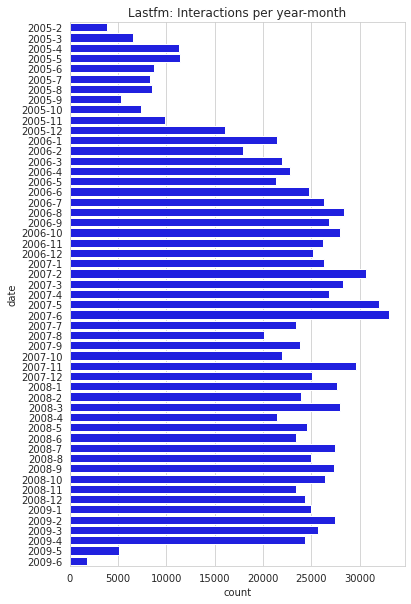

In [27]:
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [28]:
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)

In [29]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
0,user_000407,1.000000,1.000000,1.0
1,user_000957,0.981132,1.000000,1.0
2,user_000174,0.962264,0.944444,1.0
3,user_000709,0.962264,0.944444,1.0
4,user_000707,0.886792,1.000000,1.0


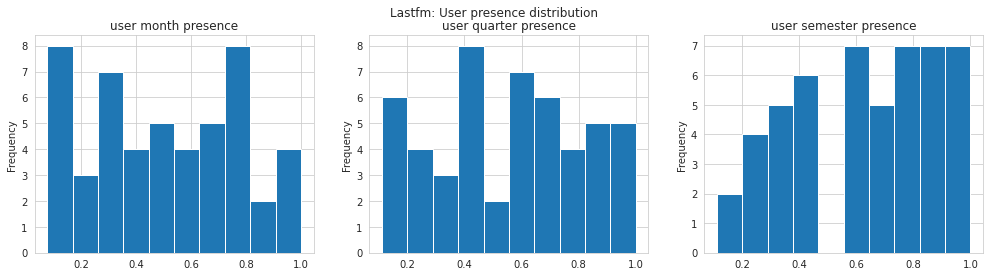

In [30]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

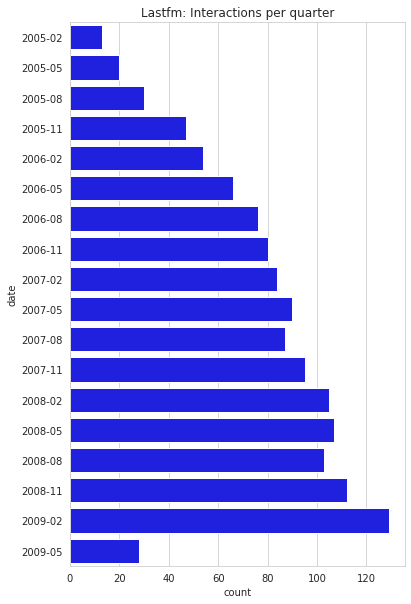

In [31]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

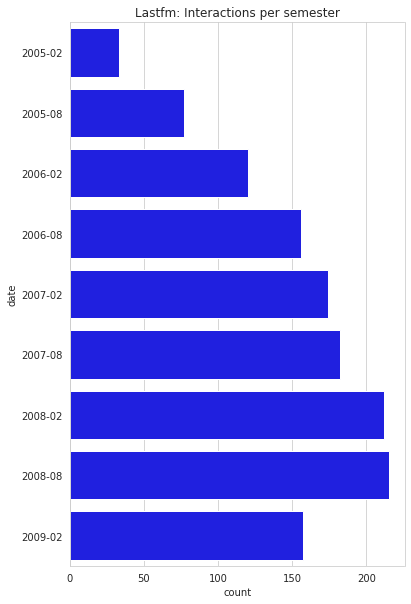

In [32]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [33]:
# defining threshold
frequency_threshold = 0.8

In [34]:
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

7 users of 50 (14.0%) occurr in 80.0% or more months.
10 users of 50 (20.0%) occurr in 80.0% or more quarters.
14 users of 50 (28.0%) occurr in 80.0% or more semesters.


In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [35]:
freq_user_quarter_info = get_frequent_user_statistics(
    interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# freq_user_quarter_info

<AxesSubplot:>

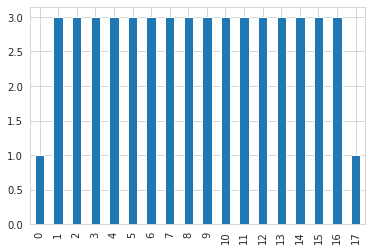

In [36]:
freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

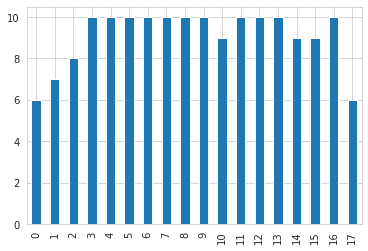

In [37]:
freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [202]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [40]:
freq_user_semester_info = get_frequent_user_statistics(
    interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# freq_user_semester_info

<AxesSubplot:>

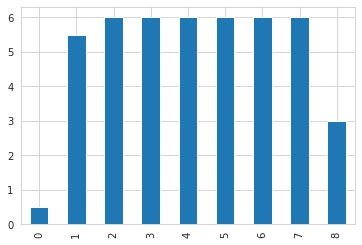

In [41]:
freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

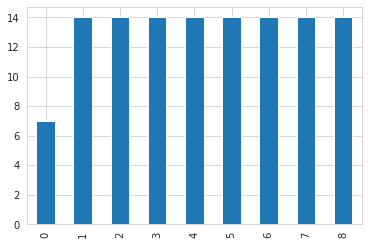

In [42]:
freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [205]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [206]:
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions.loc[frequent_users_trimestre]
user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [6]:
n_iter_bucket = 50E3

interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

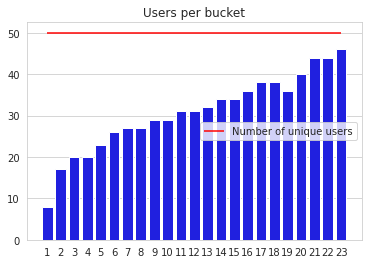

In [7]:
plot_users_per_fixed_bucket(data, user_col, interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [8]:
user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end)

In [9]:
frequency_threshold = 0.8

In [10]:
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

17 users of 50 (34.0%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [11]:
freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)

<AxesSubplot:>

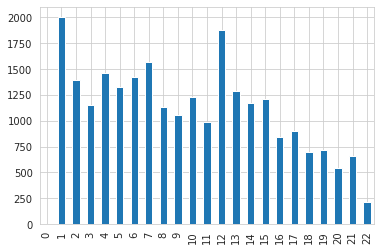

In [12]:
freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

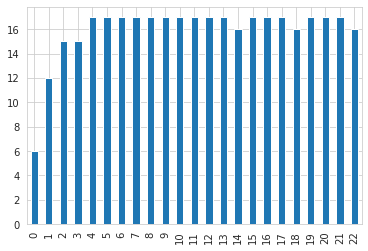

In [13]:
freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

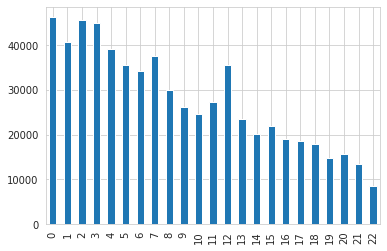

In [14]:
# frequent users interactions per bucket
plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

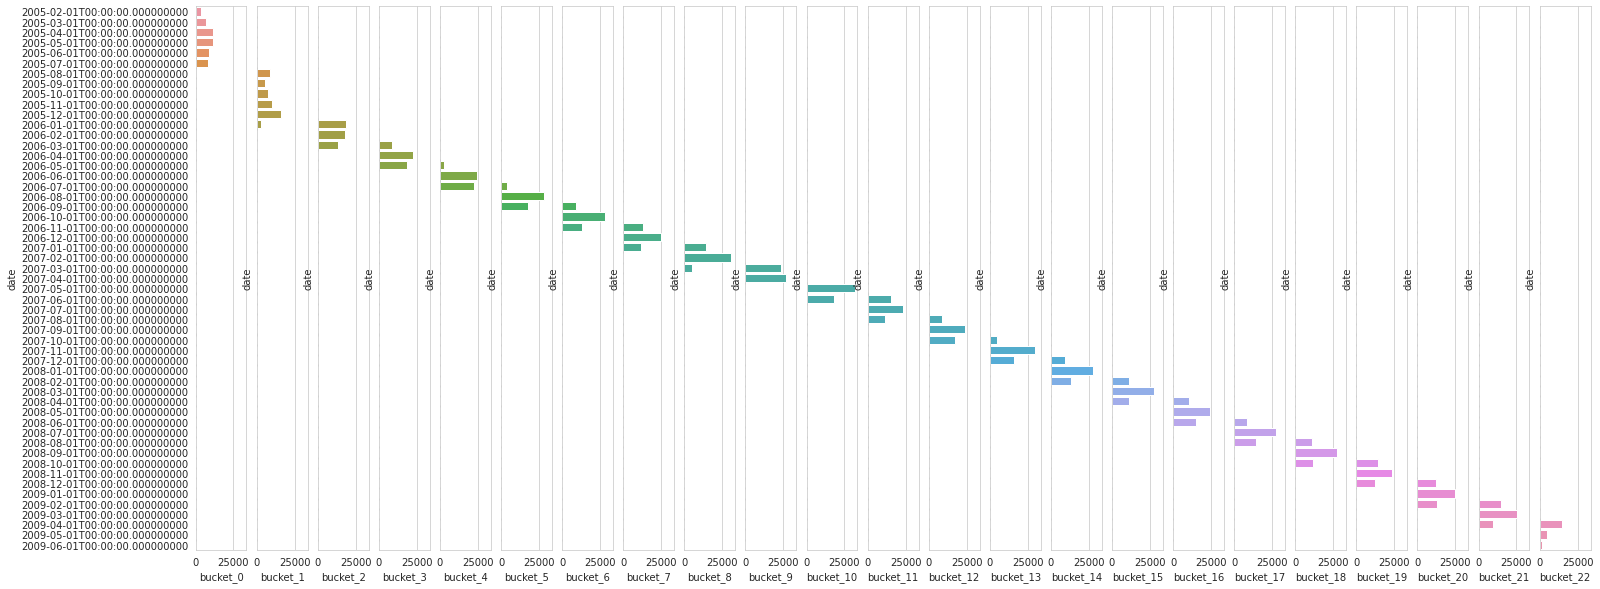

In [15]:
plot_timestamps_per_bucket(dates_fixed_buckets_df)

___
## Store Buckets

In [ ]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data['user_id'], data['item_id'])

empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [ ]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)